# Train Models using Feast historical data

* Collect historical features from Feast
* Rebuild the MNIST dataset from the features
* Train different models using the dataset
* Register models using Model Registry

In [1]:
!pip install --upgrade pip
!cat requirements.txt
!pip install -q -r requirements.txt
!pip install --no-deps --ignore-requires-python "https://github.com/opendatahub-io/ml-metadata/releases/download/v1.14.0%2Bremote.1/ml_metadata-1.14.0+remote.1-py3-none-any.whl" # need a Python 3.11 compatible version
!pip install --no-deps --ignore-requires-python "model-registry==0.1.2" # ignore dependencies because of the above override

feast==0.36.0
psycopg2>=2.9
onnx==1.14.1
onnxruntime
#tf2onnx
#typing-extensions==4.5.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.2 MB/s eta 0:00:00


## Imports and constants

In [2]:
import ast
import os
from datetime import datetime, timedelta

import boto3
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import pprint
import pandas as pd
import tensorflow as tf
import tf2onnx
from feast import FeatureStore
from IPython.display import Markdown as md
from model_registry import ModelRegistry
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

2024-04-17 15:53:50.928493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 15:53:51.788972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Note**: update this value to match the actual data

In [3]:
ts = datetime(2024, 4, 15, 12, 30, 0)

In [4]:
%env REPO_PATH=mnist_demo/feature_repo/

env: REPO_PATH=mnist_demo/feature_repo/


In [7]:
os.environ['accesskey'] = 'minio'
os.environ['secretkey'] = 'minio123'
# 'http://minio-service.kubeflow.svc.cluster.local:9000'
s3url = 'http://minio-service.feast.svc.cluster.local:9000'
bucket_name = 'feast'

## Reusable functions

In [8]:
def simpleNN():
    model = Sequential()

    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(10,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model.summary()
    return model, 'simple_NN'

In [9]:
def convolutedNN():
    model = Sequential()

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model, 'convolutedNN'

In [10]:
def evaluateModelAccuracy(model, model_name):
    y_prob = model.predict(X_test)
    y_pred = y_prob.argmax(axis=1)
    accuracy = accuracy_score(y_test,y_pred)
    print(f'Prediction accuracy for model `{model_name}` is: {round(accuracy * 100, 2)}%')

In [11]:
def testModelForSample(model, sample_id):
    plt.imshow(X_test[sample_id], cmap="Greys")
    plt.title(f'X_test[{sample_id}]:')
    plt.show()
    prediction = model.predict(X_test[sample_id].reshape(1,28,28)).argmax(axis=1)[0]
    print(f'prediction for sample {sample_id} is: ', prediction)
    print(f'**Note**: the calculated prediction {prediction} must match the number plotted above. If not, the test failed')

In [12]:
def saveModel(model, model_name):
    input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
    file_name = f"{model_name}.onnx"
    onnx.save(onnx_model, file_name)
    print(f"Saved as {file_name}")
    return file_name

In [13]:
def testModelFromFileForSample(file_name, sample_id):
    plt.imshow(X_test[sample_id], cmap="Greys")
    plt.title(f'X_test[{sample_id}]:')
    plt.show()
    model_onnx = onnx.load(file_name)
    output = [node.name for node in model_onnx.graph.output]
    print(output)

    sess = ort.InferenceSession(file_name)
    results_ort = sess.run([output[0]], {'x': X_test[sample_id].reshape(1,28,28)})
    prediction = results_ort[0].argmax(axis=1)[0]
    print(f'**Note**: the calculated prediction {prediction} must match the number plotted above. If not, the test failed')

In [14]:
def storeTrainedModel(model, model_name, file_name):
    registeredmodel_name = "mnist"
    version_name = "v."+model_name+"."+datetime.now().strftime("%Y%m%d%H%M%S")
    print(f"Will be using: {registeredmodel_name}:{version_name} in the remainder of this task")

    # Updated config for https://play.min.io:9443/
    s3 = boto3.resource(
        service_name='s3',
        # region_name='default',
        aws_access_key_id=os.environ['accesskey'],
        aws_secret_access_key=os.environ['secretkey'],
        # use_ssl=False,
        endpoint_url=s3url,
        # config=boto3.session.Config(signature_version='s3v4'),
        verify=False
    )

    odh_secret_name = f'aws-connection-{bucket_name}'
    in_bucket_path = version_name
    in_bucket_target = f'{in_bucket_path}/{file_name}'
    full_bucket_target = f's3://{bucket_name}/{in_bucket_target}'

    my_bucket = s3.Bucket(bucket_name)
    my_bucket.upload_file(file_name, in_bucket_target)

    print(f"Objects in the {bucket_name} bucket:")
    for obj in my_bucket.objects.filter():
        print(obj.key)
    return (registeredmodel_name, version_name, odh_secret_name, in_bucket_path,in_bucket_target, full_bucket_target)

In [15]:
def registerToModelRegistry(
    registeredmodel_name,
    version_name,
    odh_secret_name,
    in_bucket_path,
    in_bucket_target,
    full_bucket_target):
    registry = ModelRegistry(server_address="modelregistry-sample.feast.svc.cluster.local", port=9090, author="feast-dev@redhat.com")

    rm = registry.register_model(registeredmodel_name,
                                    full_bucket_target,
                                    model_format_name="onnx",
                                    model_format_version="1",
                                    storage_key=odh_secret_name,
                                    storage_path=in_bucket_path,
                                    version=version_name,
                                    description="demo20231121 e2e MNIST",
                                    )
    print("RegisteredModel:")
    print(registry.get_registered_model(registeredmodel_name))
    print("ModelVersion:")
    print(registry.get_model_version(registeredmodel_name, version_name))
    print("ModelArtifact:")
    print(registry.get_model_artifact(registeredmodel_name, version_name))
    return registry

## Collect historical data

In [16]:
print(f'Testing for {ts}')
entity_df = pd.DataFrame.from_dict(
    {
        "image_id": list(range(1, 70001)),
        "event_timestamp": [ts] * 70000,
    }
)

store = FeatureStore(repo_path=os.environ['REPO_PATH'])    
features = [f"mnist:feature_{i+1}" for i in range(28)]
features.append("mnist:number")
historical_df = store.get_historical_features(
    entity_df=entity_df,
    features=features,
).to_df()

Testing for 2024-04-15 12:30:00


In [17]:
len(historical_df)
assert len(historical_df)==70000

In [18]:
historical_df.head()

,image_id,event_timestamp,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,number
0,2,2024-04-15 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.33725490196078434,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0....","(0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0....","(0.0,0.0,0.0,0.0,0.0,0.0,0.10980392156862745,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098039215686274...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",0
1,4,2024-04-15 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.992...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6235294...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18823529411...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25098039215...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25098039215...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09411764705...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",1
2,7,2024-04-15 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",1
3,17,2024-04-15 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0784313...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.925...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.870588235294117...","(0.0,0.0,0.0,0.0,0.0,0.0,0.996078431372549,0.8...","(0.0,0.0,0.0,0.0,0.0,0.0,0.8470588235294118,0....","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513725490196078...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",2
4,29,2024-04-15 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...

In [19]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   image_id         70000 non-null  int64         
 1   event_timestamp  70000 non-null  datetime64[ns]
 2   feature_1        70000 non-null  object        
 3   feature_2        70000 non-null  object        
 4   feature_3        70000 non-null  object        
 5   feature_4        70000 non-null  object        
 6   feature_5        70000 non-null  object        
 7   feature_6        70000 non-null  object        
 8   feature_7        70000 non-null  object        
 9   feature_8        70000 non-null  object        
 10  feature_9        70000 non-null  object        
 11  feature_10       70000 non-null  object        
 12  feature_11       70000 non-null  object        
 13  feature_12       70000 non-null  object        
 14  feature_13       70000 non-null  objec

## Prepara dataset

Remove rows with null features

In [20]:
for id in range(28):
    historical_df.dropna(subset=[f'feature_{id+1}'], inplace=True)

Rebuild the MNIST dataset.

Goal is to recreate the `numpy` arrays that can feed the trained models.

In [21]:
images = []

Load features and revert column to rows.

**Note**: `feature_N` columns contain string representation of `list<float>`, so they must be reverted to the original data types.

The execution of these commands can take some minutes.

In [22]:
for index in range(len(historical_df)):
    image_id = historical_df['image_id'].iloc[index]
    # print(f'Rebuild {image_id} at index {index}')
    image = [list(map(float, ast.literal_eval(
        historical_df[f'feature_{id+1}'].iloc[index]))) for id in range(28)]
    images.append(image)

Extract the prediction column `number`

In [23]:
numbers = []
for index in range(len(historical_df)):
    numbers.append(int(historical_df['number'].iloc[index]))
print(len(numbers))

70000


Assign a fixed percentage of 20% to testing data

In [24]:
split = int(len(images) * 0.8)
train_images = images[:split]
test_images = images[split:]
train_numbers = numbers[:split]
test_numbers = numbers[split:]

X_train = np.array(train_images)
y_train = np.array(train_numbers)
X_test = np.array(test_images)
y_test = np.array(test_numbers)

In [49]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (56000, 28, 28)
y_train: (56000,)
X_test: (14000, 28, 28)
y_test: (14000,)


Plot some data samples to validate the transformation

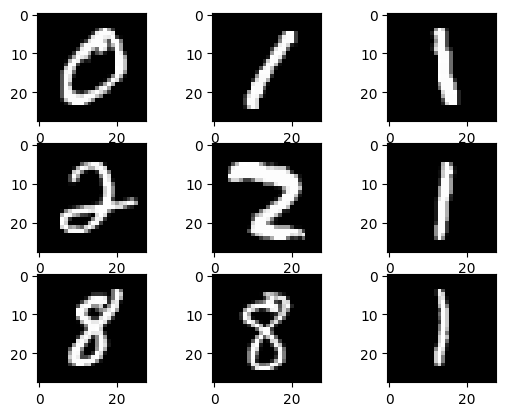

In [26]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## Train simple neural network

Let's train a simple neural network.

In [27]:
model, model_name = simpleNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 104938 (409.91 KB)
Trainable params: 104938 (409.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit(X_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10


2024-04-17 15:58:33.466303: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 140492800 exceeds 10% of free system memory.


1381/1400 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.9181

2024-04-17 15:58:37.046111: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35123200 exceeds 10% of free system memory.


1400/1400 [==============================] - 4s 2ms/step - loss: 0.2841 - accuracy: 0.9185 - val_loss: 0.1679 - val_accuracy: 0.9494
Epoch 2/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1179 - accuracy: 0.9635 - val_loss: 0.1170 - val_accuracy: 0.9647
Epoch 3/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0804 - accuracy: 0.9744 - val_loss: 0.1012 - val_accuracy: 0.9697
Epoch 4/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0607 - accuracy: 0.9804 - val_loss: 0.1017 - val_accuracy: 0.9692
Epoch 5/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0957 - val_accuracy: 0.9727
Epoch 6/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0378 - accuracy: 0.9876 - val_loss: 0.1071 - val_accuracy: 0.9705
Epoch 7/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0284 - accuracy: 0.9910 - val_loss: 0.1036 - val_accuracy: 0.9734
Epo

Evaluate model accuracy using test data

In [29]:
evaluateModelAccuracy(model, model_name)

 47/438 [==>...........................] - ETA: 0s 

2024-04-17 15:59:08.192059: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43904000 exceeds 10% of free system memory.


438/438 [==============================] - 1s 1ms/step
Prediction accuracy for model `simple_NN` is: 97.31%


### Evaluate the trained model

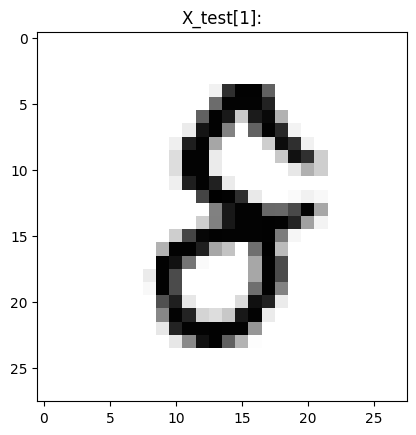

1/1 [==============================] - 0s 15ms/step
prediction for sample 1 is:  8
**Note**: the calculated prediction 8 must match the number plotted above. If not, the test failed


In [30]:
testModelForSample(model, 1)

### Save the model as ONNX file

In [31]:
file_name = saveModel(model, model_name)

Could not search for non-variable resources. Concrete function internal representation may have changed.


Saved as simple_NN.onnx


2024-04-17 15:59:17.474364: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-17 15:59:17.474508: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-04-17 15:59:17.505132: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-17 15:59:17.505315: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


### Test the saved model

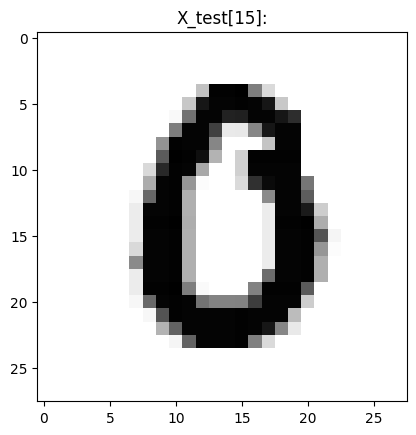

['dense_2']
**Note**: the calculated prediction 0 must match the number plotted above. If not, the test failed


In [32]:
testModelFromFileForSample(file_name, 15)

### Store the model to S3 compatible bucket

In [33]:
registeredmodel_name, version_name, odh_secret_name, in_bucket_path,in_bucket_target, full_bucket_target = storeTrainedModel(model, model_name, file_name)

Will be using: mnist:v.simple_NN.20240417155921 in the remainder of this task
Objects in the feast bucket:
v.simple_NN.20240417155921/simple_NN.onnx


In [34]:
registeredmodel_name, version_name

('mnist', 'v.simple_NN.20240417155921')

### Register with Model Registry

In [35]:
registerToModelRegistry(
    registeredmodel_name, version_name, odh_secret_name, in_bucket_path,in_bucket_target, full_bucket_target
)

RegisteredModel:
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713369565611, last_update_time_since_epoch=1713369565611, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
ModelVersion:
ModelVersion(name='v.simple_NN.20240417155921', id='2', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713369566313, last_update_time_since_epoch=1713369566313, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.simple_NN.20240417155921', author='feast-dev@redhat.com', metadata={}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='1', description='', external_id='', create_time_since_epoch=1713369567211, last_update_time_since_epoch=1713369567211, name='mnist', uri='s3://feast/v.simple_NN.20240417155921/simple_NN.onnx', state=<ArtifactState.UNKNOWN: 0>, model_format_name='onnx', model_format_version='1', storage_key='aws-connection-feast', storage_path='v.simple_NN.20240417155921', service_acc

## Train a convoluted neural network

Let's train a an alternative, a convoluted neural network:

In [36]:
model, model_name = convolutedNN()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                346176    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                      

In [37]:
history = model.fit(X_train,y_train,epochs=3)

Epoch 1/3


2024-04-17 15:59:33.539736: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 175616000 exceeds 10% of free system memory.


1750/1750 [==============================] - 19s 11ms/step - loss: 0.2605 - accuracy: 0.9216
Epoch 2/3
1750/1750 [==============================] - 19s 11ms/step - loss: 0.1145 - accuracy: 0.9643
Epoch 3/3
1750/1750 [==============================] - 18s 10ms/step - loss: 0.0836 - accuracy: 0.9740


In [38]:
evaluateModelAccuracy(model, model_name)

 40/438 [=>............................] - ETA: 1s

2024-04-17 16:00:39.114224: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43904000 exceeds 10% of free system memory.


438/438 [==============================] - 1s 3ms/step
Prediction accuracy for model `convolutedNN` is: 97.99%


### Evaluate the trained model

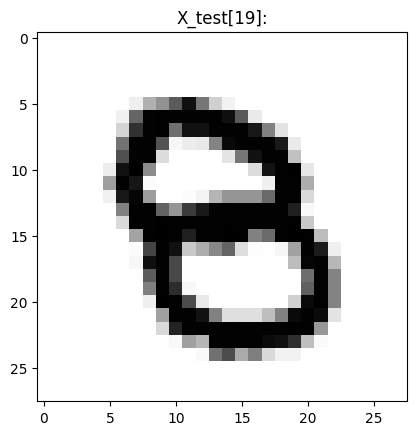

1/1 [==============================] - 0s 16ms/step
prediction for sample 19 is:  8
**Note**: the calculated prediction 8 must match the number plotted above. If not, the test failed


In [39]:
testModelForSample(model, 19)

### Save the model as ONNX file

In [40]:
file_name = saveModel(model, model_name)

Saved as convolutedNN.onnx


2024-04-17 16:00:44.966473: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-17 16:00:44.966623: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-04-17 16:00:45.003627: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-17 16:00:45.003755: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


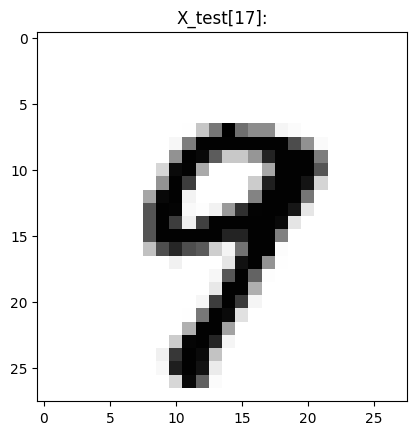

['dense_4']
**Note**: the calculated prediction 9 must match the number plotted above. If not, the test failed


In [41]:
testModelFromFileForSample(file_name, 17)

In [42]:
registeredmodel_name, version_name, odh_secret_name, in_bucket_path,in_bucket_target, full_bucket_target = storeTrainedModel(model, model_name, file_name)

Will be using: mnist:v.convolutedNN.20240417160052 in the remainder of this task
Objects in the feast bucket:
v.convolutedNN.20240417160052/convolutedNN.onnx
v.simple_NN.20240417155921/simple_NN.onnx


In [43]:
registry = registerToModelRegistry(
    registeredmodel_name, version_name + "1", odh_secret_name, in_bucket_path,in_bucket_target, full_bucket_target
)

RegisteredModel:
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713369565611, last_update_time_since_epoch=1713369565611, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
ModelVersion:
ModelVersion(name='v.convolutedNN.202404171600521', id='3', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713369653611, last_update_time_since_epoch=1713369653611, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.convolutedNN.202404171600521', author='feast-dev@redhat.com', metadata={}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='2', description='', external_id='', create_time_since_epoch=1713369654310, last_update_time_since_epoch=1713369654310, name='mnist', uri='s3://feast/v.convolutedNN.20240417160052/convolutedNN.onnx', state=<ArtifactState.UNKNOWN: 0>, model_format_name='onnx', model_format_version='1', storage_key='aws-connection-feast', storage_path='v.convolutedNN.20240417160

## Inspect Model Registry

In [44]:
models = registry._api.get_registered_models()
assert len(models)==1, f"Found {len(models)} instead of just 1"
registered_model = models[0]
print(registered_model)

RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1713369565611, last_update_time_since_epoch=1713369565611, state=<ContextState.LIVE: 'LIVE'>, name='mnist')


In [47]:
# Utility function to archive old versions
# Uncomment and place the desired model version ids in the range() configuration 
# and the desired model id in the call to upsert_model_version()

from model_registry.types import ContextState
# for id in range(3,10):
#     m = registry._api.get_model_version_by_id(id)
#     if m != None:
#         m.state=ContextState.ARCHIVED
#         try:
#             res = registry._api.upsert_model_version(m, 1)
#         except Exception as e:
#             print(f"AlreadyExistsError for {id}")

In [48]:
registered_model_id = registered_model.id
live_model_versions = [m for m in registry._api.get_model_versions(registered_model_id=registered_model_id) if m.state!=ContextState.ARCHIVED]
assert len(live_model_versions)==2, f"Found {len(live_model_versions)} instead of just 2"

for live_model_version in live_model_versions:
    print(live_model_version)

ModelVersion(name='v.simple_NN.20240417155921', id='2', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713369566313, last_update_time_since_epoch=1713369566313, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.simple_NN.20240417155921', author='feast-dev@redhat.com', metadata={}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelVersion(name='v.convolutedNN.202404171600521', id='3', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1713369653611, last_update_time_since_epoch=1713369653611, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v.convolutedNN.202404171600521', author='feast-dev@redhat.com', metadata={}, artifacts=NOTHING, _registered_model_id=NOTHING)
